# Transfer Learning
Here a VGGNet trained on the ImageNet dataset will be used as a feature extractor. The idea here is to keep all the convolutional layers, but replace the final fully-connected layer with a new classifier, that will be trained on top of the existing network.

Steps:
- Use all but the last fully-connected layer as a fixed feature extractor.
- Define a new, final classification layer and train the network.

Dataset:
VGGNet will be used to classify images of flowers.

In [2]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and prepare the data
Download the flower data from this [link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), save it in the home directory of this notebook and extract the zip file to get the directory `flower_photos/`. Make sure the directory has this exact name for accessing data: "flower_photos".

In [4]:
# Define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# Classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
# Load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# Print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [6]:
# Define dataloader parameters
batch_size = 20
num_workers=0

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

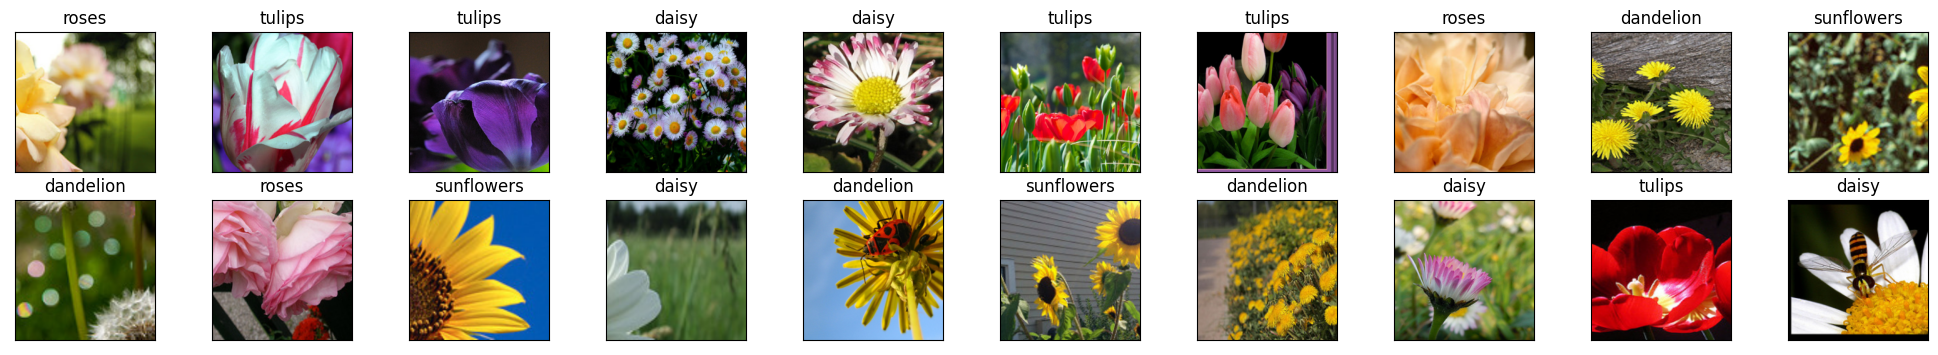

In [7]:
# Visualize some sample data

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Define the Network Architecture

The following steps are necessary:

- Load in a pre-trained VGG16 model
- "Freeze" all the parameters, so the net acts as a fixed feature extractor
- Remove the last layer
- Replace the last layer with a linear classifier

In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True) # Size of the file: 528 MB!

# Print out the model structure
print(vgg16)

C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features) 

4096
1000


In [10]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

## Modification of the final classifier layer

In [11]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# Add last linear layer (n_inputs -> 5 flower classes)
# New layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# If GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# Check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

5
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

# Training phase

In [12]:
import torch.optim as optim

# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [13]:
# Number of epochs to train the model
n_epochs = 5

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    
    # Model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            torch.save(vgg16.state_dict(), 'ftm_transfer_model_5_epochs.pt')
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5792279839515686
Epoch 1, Batch 40 loss: 1.3696731269359588
Epoch 1, Batch 60 loss: 1.2046365737915039
Epoch 1, Batch 80 loss: 1.1300716012716294
Epoch 1, Batch 100 loss: 1.0593180835247040
Epoch 1, Batch 120 loss: 0.9922837674617767
Epoch 1, Batch 140 loss: 0.9426144719123840
Epoch 2, Batch 20 loss: 0.8563098847866059
Epoch 2, Batch 40 loss: 0.8630582481622696
Epoch 2, Batch 60 loss: 0.8105427354574204
Epoch 2, Batch 80 loss: 0.7988875955343246
Epoch 2, Batch 100 loss: 0.7610419452190399
Epoch 2, Batch 120 loss: 0.7416832596063614
Epoch 2, Batch 140 loss: 0.7982873558998108
Epoch 3, Batch 20 loss: 0.7413925915956497
Epoch 3, Batch 40 loss: 0.7491185754537583
Epoch 3, Batch 60 loss: 0.6252556502819061
Epoch 3, Batch 80 loss: 0.7194588094949722
Epoch 3, Batch 100 loss: 0.6834629207849503
Epoch 3, Batch 120 loss: 0.6895314082503319
Epoch 3, Batch 140 loss: 0.6646749705076218
Epoch 4, Batch 20 loss: 0.7170266181230545
Epoch 4, Batch 40 loss: 0.6970141798257827
Ep

In [14]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location=torch.device('cpu')

vgg16.load_state_dict(torch.load('ftm_transfer_model_5_epochs.pt', map_location=map_location))

<All keys matched successfully>

# Testing Phase

In [15]:
# Track test loss over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# Iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.562865

Test Accuracy of daisy: 72% (67/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 69% (63/91)
Test Accuracy of sunflowers: 81% (82/101)
Test Accuracy of tulips: 75% (93/124)

Test Accuracy (Overall): 79% (427/540)


# Results

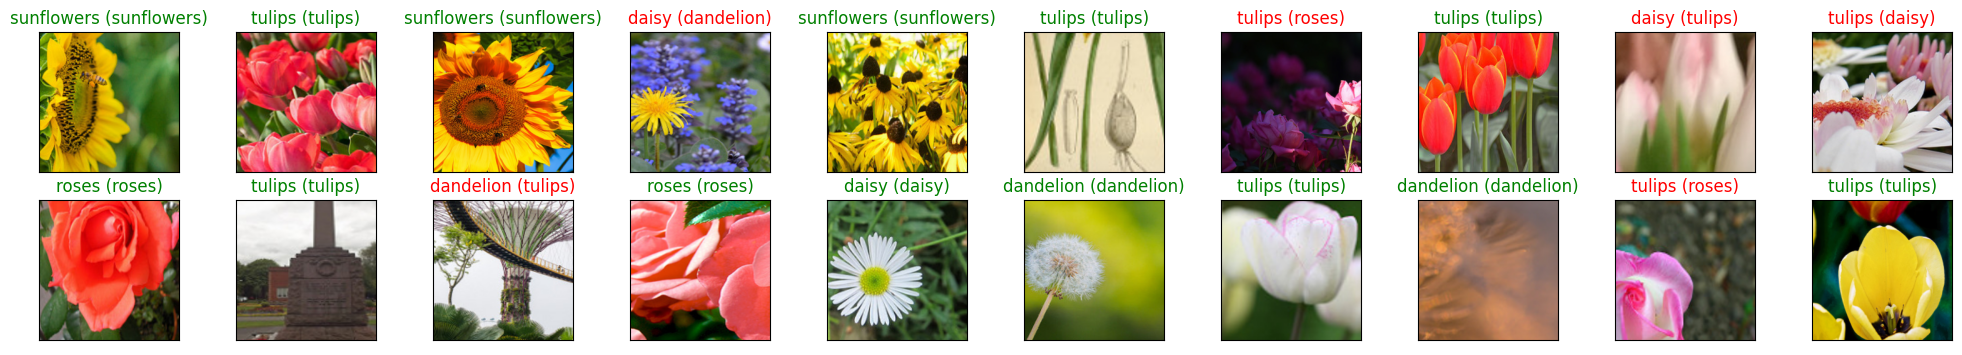

In [16]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# Move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

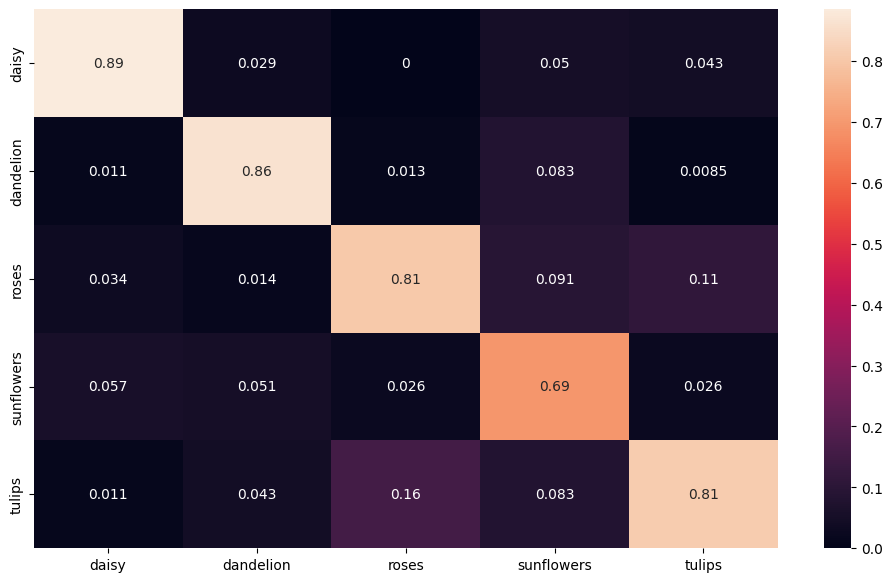

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# iterate over test data
y_pred = []
y_true = []

for inputs, labels in test_loader:
       
        if torch.cuda.is_available():
            output = vgg16(inputs.cuda()) # Feed Network
        else:
            output = vgg16(inputs.cpu()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
classes = ('daisy', 'dandelion', 'roses', 'sunflowers', 'tulips') # Build confusion matrix

cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 5, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output_transfer_5_epochs.png')